## This Notebook gives an example on how to quantify intra and extranuclear HTT aggregates (Figure 3 and Supplementary Figure 8 in the manuscript)

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.spatial import KDTree
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from adjustText import adjust_text

In [2]:
adata=sc.read_h5ad('../adata_0803_0908_f_AGG_orig.h5ad')

In [3]:
##################################################
#### FIGURE 3C: Spatial projection of Intra and Extranuclear Aggregates
##################################################

In [4]:
def plot_AGG_scdata(scdata, obs='Agg', sz_min=1, sz_med=5, sz_max=30, transpose=1, flipx=1, flipy=1, tag='X_spatial'):
    fig = plt.figure(figsize=(15, 15), facecolor="white")
    x, y = (scdata.obsm[tag] * [-flipx, -flipy])[:, ::-transpose].T
    plt.scatter(x, y, c='gray', s=sz_min, marker='.')
    intranuclear_inds = scdata.obs[obs] == 1
    extranuclear_inds = scdata.obs[obs] == 0

    x_extra = x[extranuclear_inds]
    y_extra = y[extranuclear_inds]
    plt.scatter(x_extra, y_extra, c='#32CD32', s=sz_med, marker='.', label='Extranuclear', edgecolors='black')
    
    x_intra = x[intranuclear_inds]
    y_intra = y[intranuclear_inds]
    plt.scatter(x_intra, y_intra, c='magenta', s=sz_max, marker='.', label='Intranuclear', edgecolors='black')

    plt.grid(False)
    plt.axis("off")
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()

    return fig

#

In [5]:
H2=adata[adata.obs['patient']=='H2'].copy()

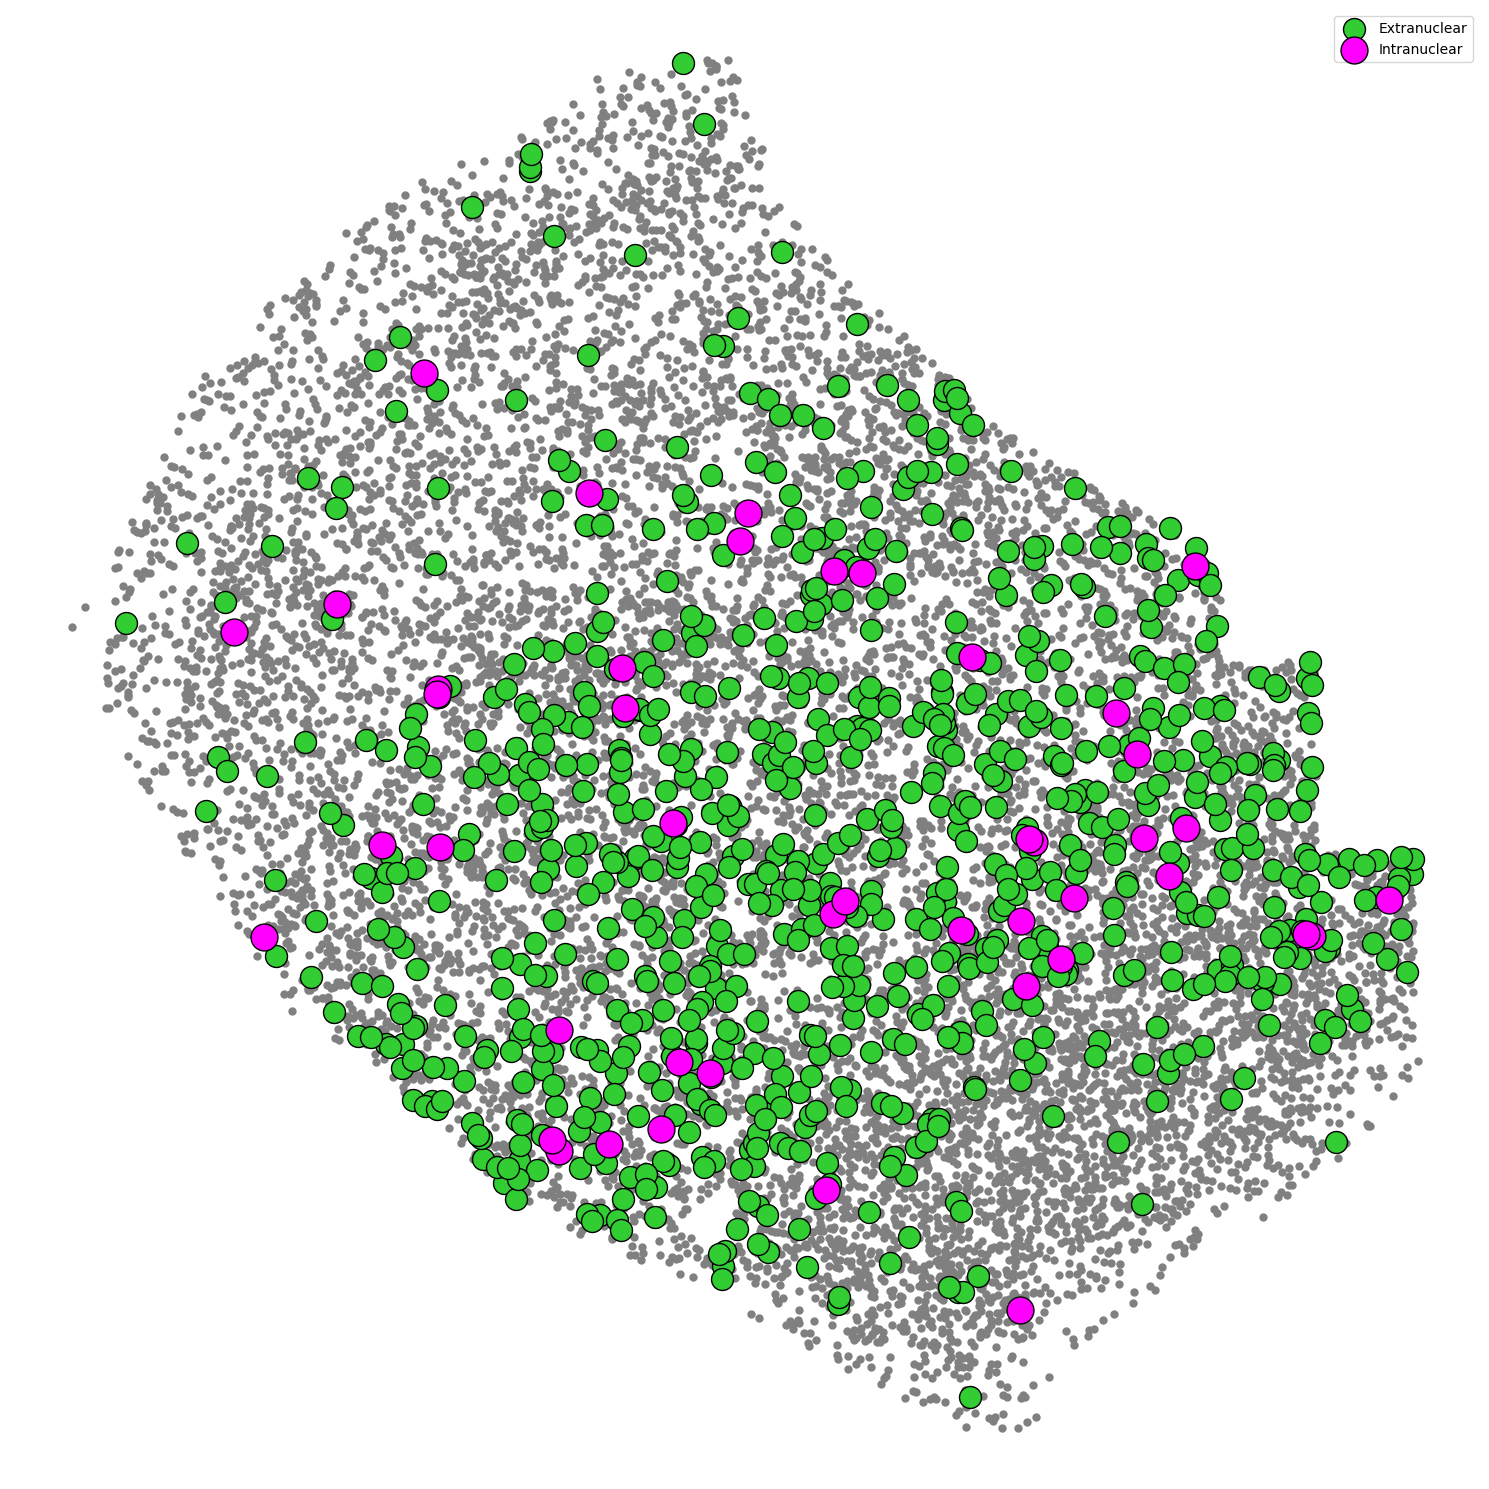

In [6]:
plot_AGG_scdata(H2, obs='Agg', sz_min=100,  sz_med=1000,sz_max=1500, transpose=-1, flipx=1, flipy=1, tag='X_spatial');

### Quantification of total cells with Aggregates per patient, save as 'processed_data/agg_count_summary.csv' (related to Figure 3D and Supplementary Figure 8B-C)

In [7]:
##################################################
#### SUPPLEMENTARY FIGURE 8B: Plot quantification of total aggregates per patient
##################################################

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/3517572247.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_df.groupby(['patient', 'Agg_type'])
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(groupe

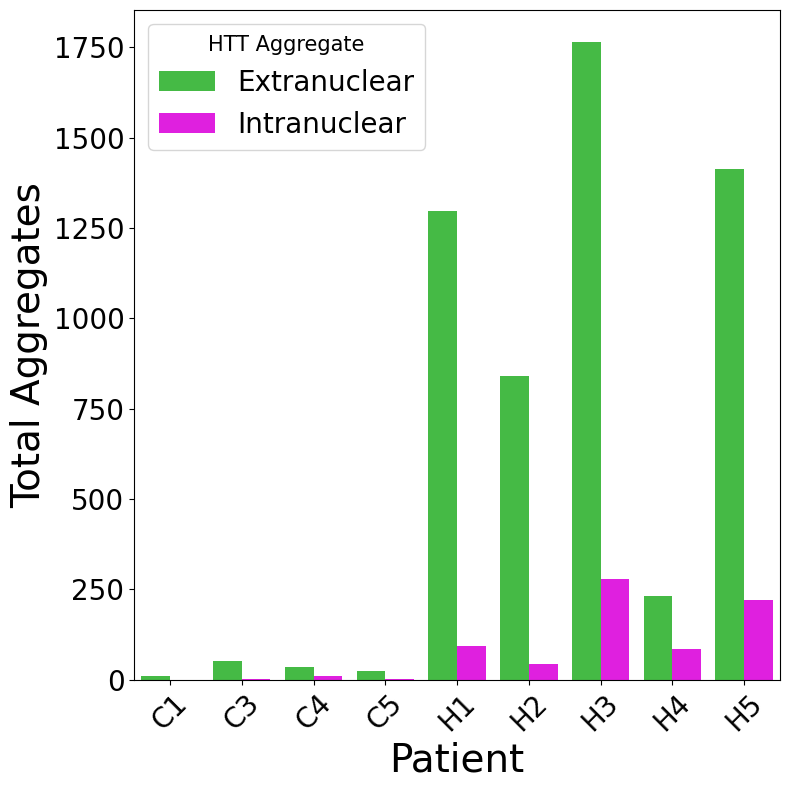

In [8]:
data_df = adata.obs[['patient', 'Agg']].copy()
data_df['Agg_type'] = data_df['Agg'].map({1: 'Intranuclear', 0: 'Extranuclear'})

agg_summary = (
    data_df.groupby(['patient', 'Agg_type'])
    .size()
    .reset_index(name='total_Agg')
)

agg_summary['Agg_type'] = agg_summary['Agg_type'].fillna('Not Aggregate')

plt.figure(figsize=(8, 8))
sns.barplot(
    data=agg_summary,
    x='patient',
    y='total_Agg',
    hue='Agg_type',
    palette={'Intranuclear':'magenta', 'Extranuclear': '#32CD32',  'Not Aggregate': 'gray'}
)

plt.xlabel('Patient', fontsize=28)
plt.ylabel('Total Aggregates', fontsize=28)
plt.legend(title='HTT Aggregate', fontsize=20, title_fontsize=15)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.show()


In [9]:
total_cells = adata.obs['patient'].value_counts()
agg_summary['percent_Agg'] = (
    agg_summary['total_Agg'] /
    agg_summary['patient'].map(total_cells).astype(float)
) * 100
agg_summary

,patient,Agg_type,total_Agg,percent_Agg
0,C1,Extranuclear,10,0.065066
1,C1,Intranuclear,0,0.000000
2,C3,Extranuclear,52,0.216207
3,C3,Intranuclear,1,0.004158
4,C4,Extranuclear,34,0.128099
5,C4,Intranuclear,10,0.037676
6,C5,Extranuclear,25,0.096607
7,C5,Intranuclear,2,0.007729
8,H1,Extranuclear,1298,7.192730
9,H1,Intranuclear,94,0.520891


In [10]:
agg_summary.to_csv('processed_data/agg_count_summary.csv')

### Quantification of percent cells with intranuclear aggregates by cell type, save as 'intra_agg_counts_major_clusters.csv' and 'intra_agg_counts_excitatory_neurons.csv' (related to Figure 3F-G an Supplementary Figure 8I)

In [11]:
general_map = {
    # Inhibitory neurons
    "LAMP5": "Inhibitory Neurons",
    "SNCG": "Inhibitory Neurons",
    "VIP": "Inhibitory Neurons",
    "SST": "Inhibitory Neurons",
    "PVALB": "Inhibitory Neurons",
    "Chandelier": "Inhibitory Neurons",

    # Excitatory neurons
    "L2.IT": "Excitatory Neurons",
    "L3.IT": "Excitatory Neurons",
    "L4.IT": "Excitatory Neurons",
    "L5.IT": "Excitatory Neurons",
    "L5.ET": "Excitatory Neurons",
    "L5.6.NP": "Excitatory Neurons",
    "L6.IT": "Excitatory Neurons",
    "L6.CT": "Excitatory Neurons",
    "L6.Car3": "Excitatory Neurons",
    "L6b": "Excitatory Neurons",

    # Astrocytes
    "Astro.GM": "Astrocytes",
    "Astro.WM": "Astrocytes",
    "Astro.P": "Astrocytes",

    # OPCs
    "OPC": "OPC",

    # Oligodendrocytes
    "Oligo.GM": "Oligodendrocytes",
    "Oligo.WM": "Oligodendrocytes",

    # Others
    "Endo": "Endothelial",
    "VLMC": "VLMC",
    "Microglia": "Microglia",
}

adata.obs['cluster_general'] = adata.obs['cluster_names'].map(general_map)

In [12]:
data_df = adata.obs[['patient', 'cluster_general', 'Agg']].copy()
data_df['Agg'] = data_df['Agg'].fillna(False).astype('bool')

agg_percentages_all = []
for (patient, cluster_name), group in data_df.groupby(['patient', 'cluster_general']):
    percent = group['Agg'].mean() * 100
    agg_percentages_all.append({
        'cluster_general': cluster_name,
        'patient': patient,
        'percent_with_agg': percent,
    })

agg_percentages_all_df = pd.DataFrame(agg_percentages_all)
agg_percentages_all_df = agg_percentages_all_df.pivot(index='cluster_general', columns='patient', values='percent_with_agg')

agg_percentages_all_df = agg_percentages_all_df.sort_index()
agg_percentages_all_df.to_csv("processed_data/intra_agg_counts_major_clusters.csv")
print(agg_percentages_all_df)


patient              C1        C3        C4        C5        H1        H2  \
cluster_general                                                             
Astrocytes          0.0  0.024301  0.031878  0.028257  0.298240  0.331126   
Endothelial         0.0  0.000000  0.315259  0.000000  0.236780  0.000000   
Excitatory Neurons  0.0  0.000000  0.056657  0.000000  1.435148  1.150483   
Inhibitory Neurons  0.0  0.000000  0.000000  0.000000  0.173732  0.174978   
Microglia           0.0  0.000000  0.000000  0.000000  0.385505  0.214592   
OPC                 0.0  0.000000  0.000000  0.000000  0.335196  0.187617   
Oligodendrocytes    0.0  0.000000  0.009735  0.018002  0.400863  0.177096   
VLMC                0.0  0.000000  0.000000  0.000000  0.182315  0.000000   

patient                   H3        H4        H5  
cluster_general                                   
Astrocytes          0.330132  0.036114  0.294310  
Endothelial         0.217707  0.174672  0.058343  
Excitatory Neurons  4.552

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/1891997896.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (patient, cluster_name), group in data_df.groupby(['patient', 'cluster_general']):


In [13]:
Exc=adata[adata.obs['cluster_general']=='Excitatory Neurons'].copy()

In [14]:
data_df = Exc.obs[['patient', 'cluster_names', 'Agg']].copy()
data_df['Agg'] = data_df['Agg'].fillna(False).astype('bool')

agg_percentages_exc = []
for (patient, cluster_name), group in data_df.groupby(['patient', 'cluster_names']):
    percent = group['Agg'].mean() * 100
    agg_percentages_exc.append({
        'cluster_names': cluster_name,
        'patient': patient,
        'percent_with_agg': percent,
    })

agg_percentages_exc_df = pd.DataFrame(agg_percentages_exc)
agg_percentages_exc_df = agg_percentages_exc_df.pivot(index='cluster_names', columns='patient', values='percent_with_agg')

agg_percentages_exc_df = agg_percentages_exc_df.sort_index()
agg_percentages_exc_df.to_csv("processed_data/intra_agg_counts_excitatory_neurons.csv")
print(agg_percentages_exc_df)


patient         C1   C3        C4   C5        H1        H2         H3  \
cluster_names                                                           
L2.IT          0.0  0.0  0.000000  0.0  0.559105  0.292398   0.753296   
L3.IT          0.0  0.0  0.000000  0.0  1.835749  1.571709   2.695418   
L4.IT          0.0  0.0  0.132802  0.0  0.511945  0.000000   0.538358   
L5.6.NP        0.0  0.0  0.000000  0.0  0.000000  0.000000   0.000000   
L5.ET          0.0  0.0  2.173913  0.0  3.846154  0.000000   2.173913   
L5.IT          0.0  0.0  0.000000  0.0  3.080569  0.842697   2.652826   
L6.CT          0.0  0.0  0.000000  0.0  2.298851  0.609756   3.873239   
L6.Car3        0.0  0.0  0.000000  0.0  0.000000  0.000000   4.575163   
L6.IT          0.0  0.0  0.170358  0.0  4.419890  1.661130  11.852861   
L6b            0.0  0.0  0.000000  0.0  0.000000  4.827586  21.428571   

patient              H4         H5  
cluster_names                       
L2.IT          1.246537   2.396166  
L3.IT       

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2890757510.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (patient, cluster_name), group in data_df.groupby(['patient', 'cluster_names']):


### Plot Aggregate Size

In [15]:
##################################################
#### SUPPLEMENTARY FIGURE 8D:
##################################################

In [16]:
Agg = adata[adata.obs['Agg'].notna()].copy()

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


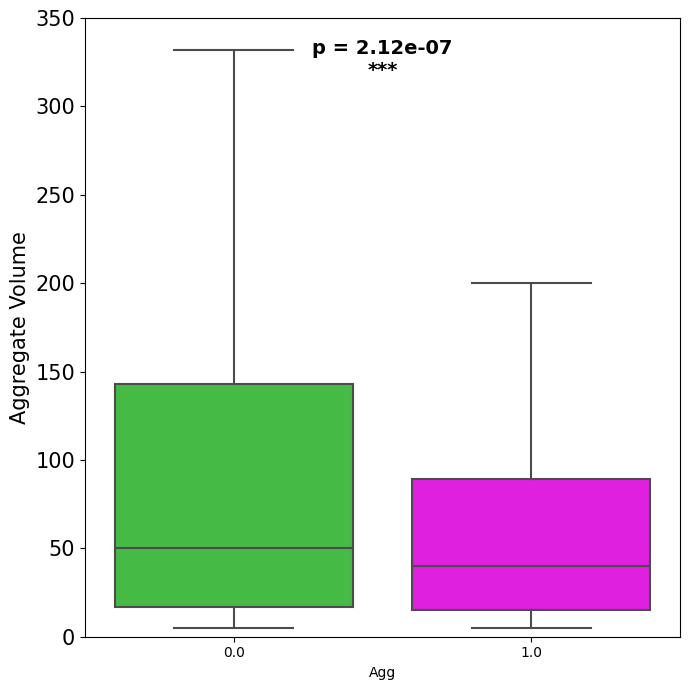

In [17]:
palette = {False: "#32CD32", True: "magenta"}

plt.figure(figsize=(7, 7))
sns.boxplot(
    data=Agg.obs,
    x='Agg',
    y='Agg_vol',
    palette=palette,
    showfliers=False
)

plt.yticks(size=15)
plt.ylabel('Aggregate Volume', size=15)
plt.title('')
plt.ylim(0, 350)

group_true = Agg.obs.loc[Agg.obs['Agg'] == True, 'Agg_vol']
group_false = Agg.obs.loc[Agg.obs['Agg'] == False, 'Agg_vol']

stat, pval = stats.mannwhitneyu(group_true, group_false, alternative='two-sided')

if pval < 0.001:
    stars = '***'
elif pval < 0.01:
    stars = '**'
elif pval < 0.05:
    stars = '*'
else:
    stars = 'ns'  # not significant

plt.text(
    0.5,                           
    300 * 1.05, 
    f'p = {pval:.2e}\n{stars}',
    ha='center',
    va='bottom',
    fontsize=14,
    color='black',
    fontweight='bold'
)

plt.tight_layout()
plt.show()

### Quantification of Extranuclear Aggregates per Cortical Layer

In [18]:
colors = ['#8c564b','#e377c2','#4363d8', '#bfef45', '#42d4f4','#f58231','#e6194B']
colors_light = ['#c49c94', '#f7b6d2',  '#9fbfff',  '#d9f0a3', '#a6e7f4', '#ffb482', '#ff9aa2']
colors_light_o = ['#e377c2','#4363d8', '#bfef45', '#42d4f4','#f58231','#e6194B', '#8c564b']
layers = ['Astro.WM','Astro.P','L2.IT','L3.IT','L4.IT','L5.IT','L6.IT']

In [19]:
##################################################
#### SUPPLEMENTARY FIGURE 8F:
##################################################

In [20]:
adata_xraw = sc.read_h5ad(r'../adata_0803_0908_f_AGG_new.h5ad')
HD_adata = adata_xraw[adata_xraw.obs['HD']==True].copy()

In [21]:
upatientHD= HD_adata.obs['patient'].unique()

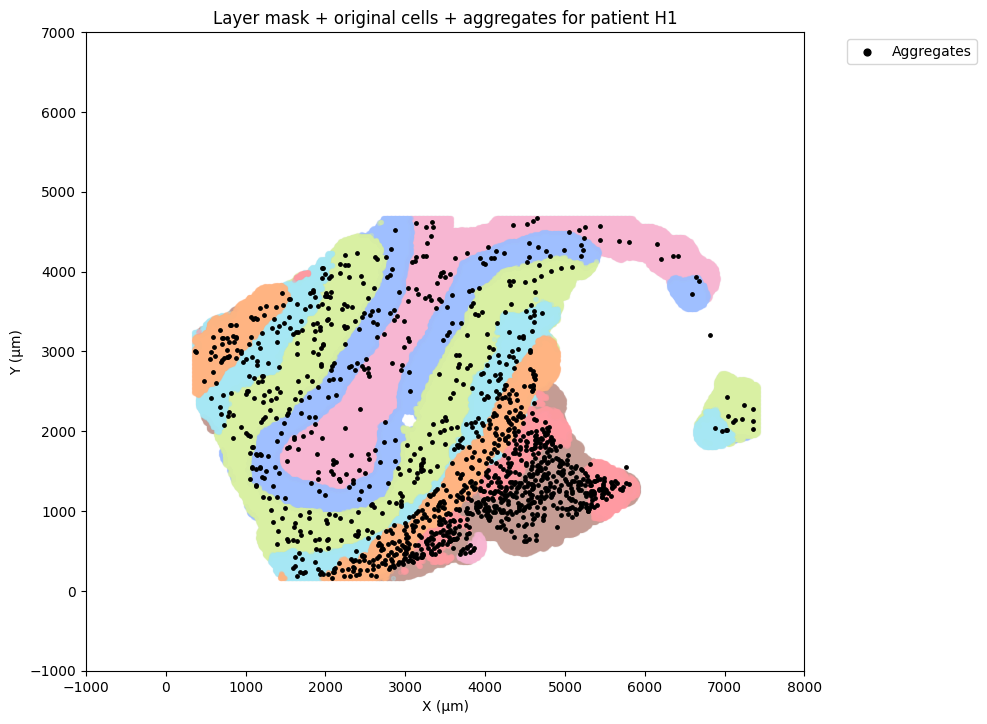

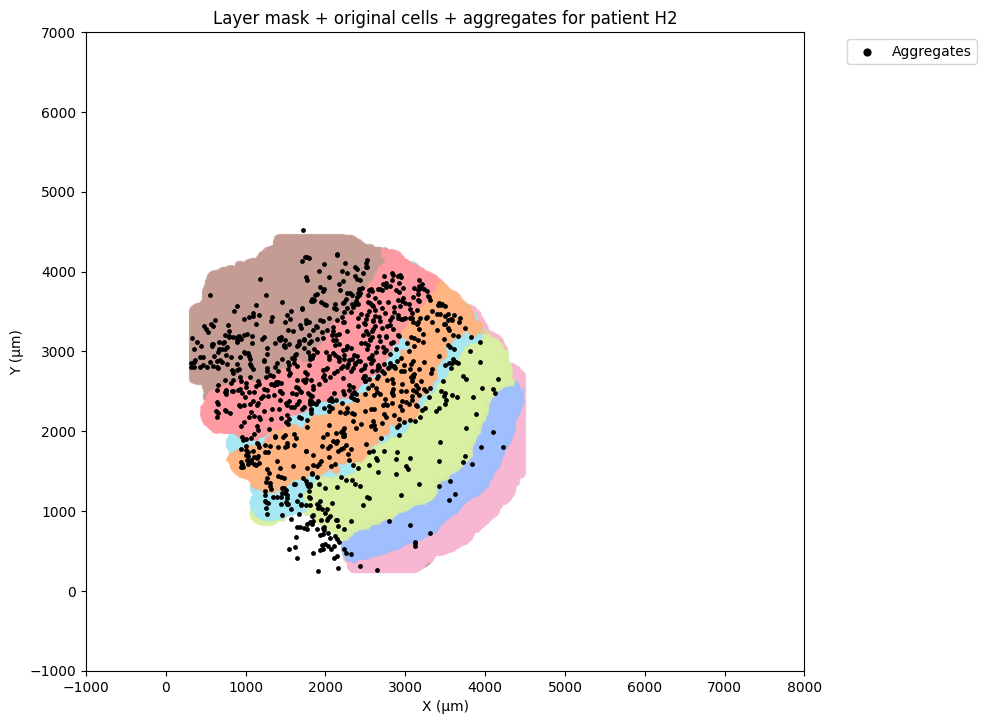

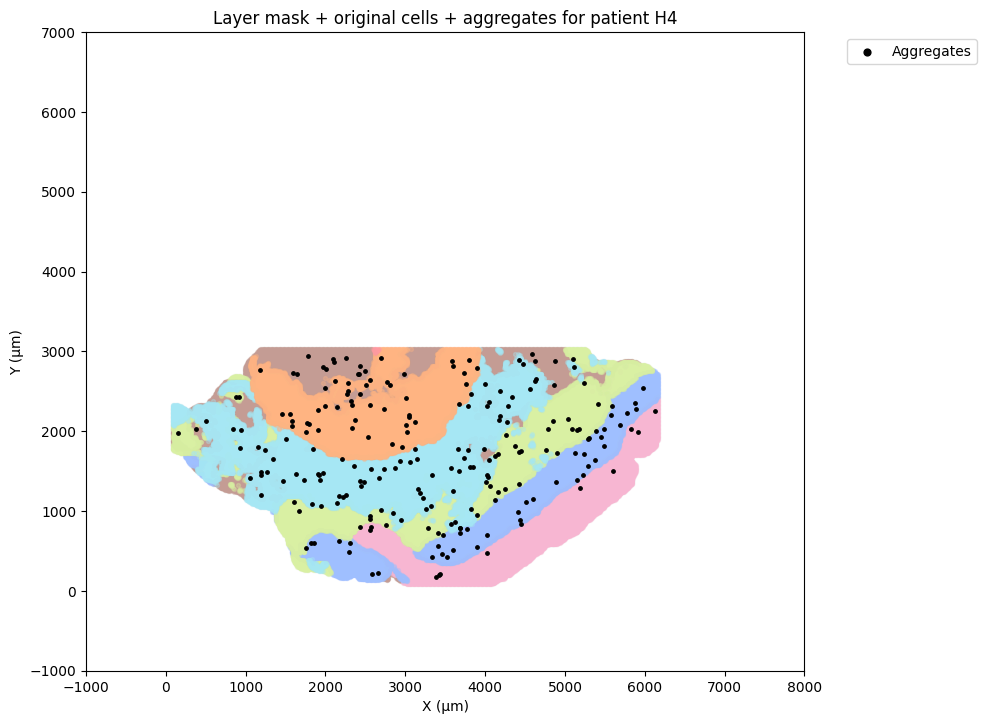

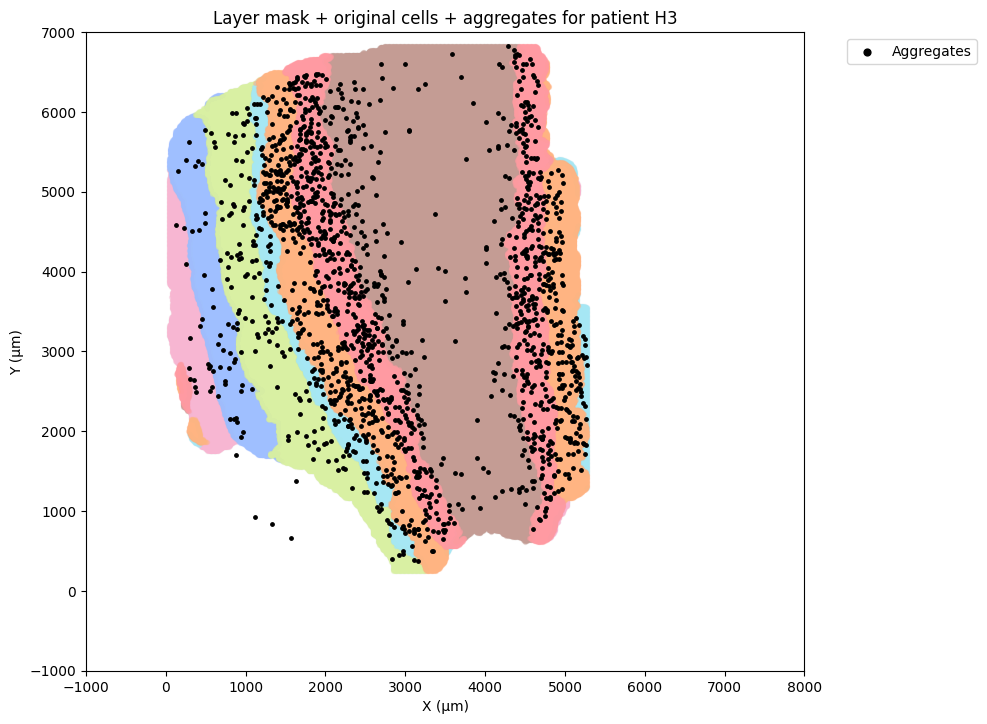

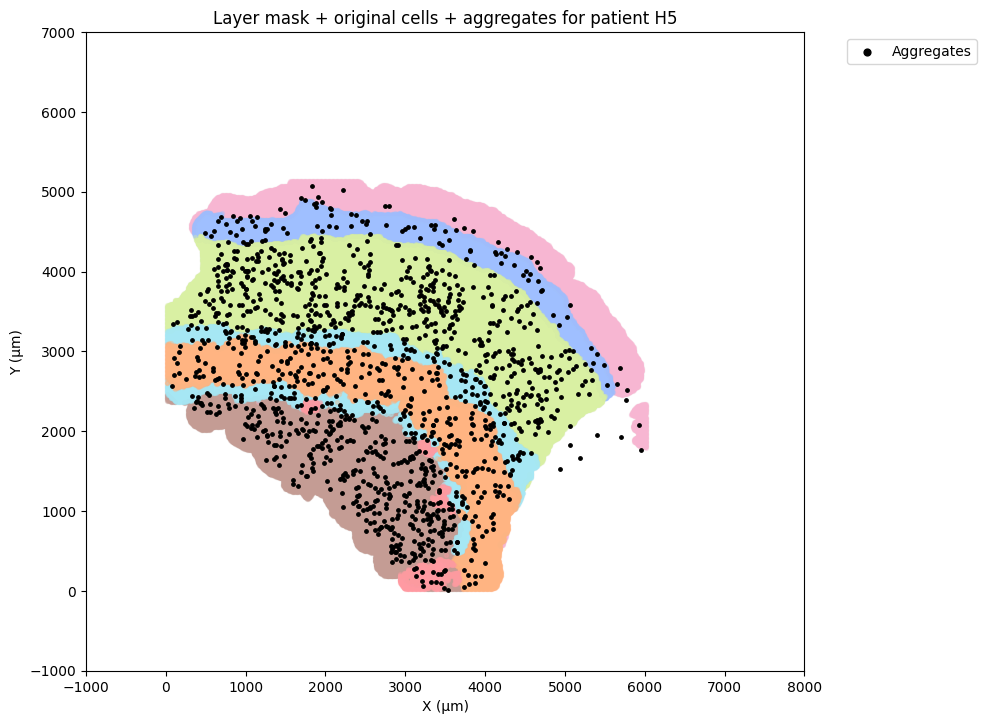

In [22]:
res = 10  # resolution in microns

all_counts = []
all_areas = []

for pt in upatientHD:
    scdata_ = HD_adata[HD_adata.obs['patient'] == pt]

    X = scdata_.obsm['X_spatial_raw'].copy()
    cluster_names = np.array(scdata_.obs['cluster_names'])
    iscelltype = np.in1d(cluster_names, layers)
    X = X[iscelltype]
    cluster_names = cluster_names[iscelltype]

    agg_mask = scdata_.obs['Agg'] == 0 
    XAgg = scdata_.obsm['X_spatial_raw'][agg_mask]

    m = np.min(X, axis=0)
    M = np.max(X, axis=0)
    Xp = np.array([(x_, y_) for x_ in np.arange(m[0], M[0], res)
                              for y_ in np.arange(m[1], M[1], res)])

    tree = KDTree(X)
    dd, nn = tree.query(Xp, k=100)
    cls = cluster_names[nn]
    cls[dd > 200] = ''

    cts_per_layer = np.array([np.sum(cls == l, axis=-1) for l in layers]).T
    layersF = np.argmax(cts_per_layer, axis=-1)
    ncells = np.sum(cts_per_layer, axis=1)

    valid_mask = ncells > 1
    Xpf = Xp[valid_mask]
    layersF = layersF[valid_mask]

    area_counts = {layer: 0 for layer in layers}
    for i, layer in enumerate(layers):
        area_counts[layer] = np.sum(layersF == i) * (res ** 2)  # in µm²

    agg_layer_counts = {layer: 0 for layer in layers}
    agg_mask = scdata_.obs['Agg'] == 0
    XAgg = scdata_.obsm['X_spatial_raw'][agg_mask]
    if len(XAgg) > 0:
        mask_tree = KDTree(Xpf)
        dists, idxs = mask_tree.query(XAgg)
        for l_idx in layersF[idxs]:
            agg_layer_counts[layers[l_idx]] += 1

    row_counts = {"patient": pt}
    row_counts.update(agg_layer_counts)
    all_counts.append(row_counts)

    row_area = {"patient": pt}
    row_area.update(area_counts)
    all_areas.append(row_area)

    # PLOT
    plt.figure(figsize=(10, 10))
    for i, layer in enumerate(layers):
        plt.scatter(Xpf[layersF == i, 0], Xpf[layersF == i, 1],
                    s=8, c=colors_light[i], alpha=0.3)

    if len(XAgg) > 0:
        plt.scatter(XAgg[:, 0], XAgg[:, 1],
                    s=6, c='black', marker='o', label='Aggregates')

    plt.title(f"Layer mask + original cells + aggregates for patient {pt}")
    plt.xlabel('X (µm)')
    plt.ylabel('Y (µm)')
    plt.gca().invert_yaxis()
    plt.xlim(-1000,8000)
    plt.ylim(-1000,7000)
    plt.gca().set_aspect('equal') 
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [23]:
##################################################
#### SUPPLEMENTARY FIGURE 8E:
##################################################

In [24]:
agg_counts_df = pd.DataFrame(all_counts)
layer_area_df = pd.DataFrame(all_areas)

print("\n Aggregate counts per layer per patient:")
print(agg_counts_df)

print("\nMask area per layer per patient (µm²):")
print(layer_area_df)


 Aggregate counts per layer per patient:
  patient  Astro.WM  Astro.P  L2.IT  L3.IT  L4.IT  L5.IT  L6.IT
0      H1       346      101    112    223    136    243    179
1      H2       229       10     18    122    108    204    276
2      H4        34       13     46     38     67     37      0
3      H3       283       17     41    136    105    506    666
4      H5       377       35     83    523    194    213     20

Mask area per layer per patient (µm²):
  patient  Astro.WM  Astro.P    L2.IT    L3.IT    L4.IT    L5.IT    L6.IT
0      H1   1900300  3761300  3424700  5338800  2229500  2053200   931500
1      H2   3103400   979200  1173200  2525300   903900  2102500  2110500
2      H4   2014900  1909200  1900300  2374200  3478500  2170400     3000
3      H3  11340600  1112500  1845400  3386100  1334400  4371500  4475400
4      H5   3943600  2387300  1874300  6504400  1998300  3191800   227100


In [25]:
density_df = agg_counts_df.copy()
for layer in layers:
    density_df[layer] = agg_counts_df[layer] / layer_area_df[layer]  * 1e6 # agg per µm²

In [26]:
order = ['Astro.P','L2.IT','L3.IT','L4.IT','L5.IT','L6.IT','Astro.WM']

rename_map = {
    'Astro.P': 'Peripheral',
    'L2.IT': 'Layer 2',
    'L3.IT': 'Layer 3',
    'L4.IT': 'Layer 4',
    'L5.IT': 'Layer 5',
    'L6.IT': 'Layer 6',
    'Astro.WM': 'White Matter'
}

order_display = [rename_map[o] for o in order]

density_long = density_df.melt(
    id_vars="patient",
    value_vars=layers,
    var_name="Layer",
    value_name="Agg_Density"
)

density_long['Layer'] = density_long['Layer'].map(rename_map)

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2481750151.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


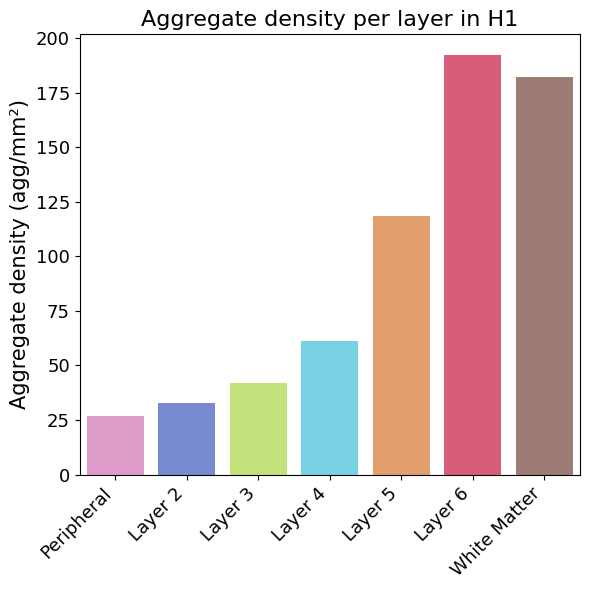

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2481750151.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


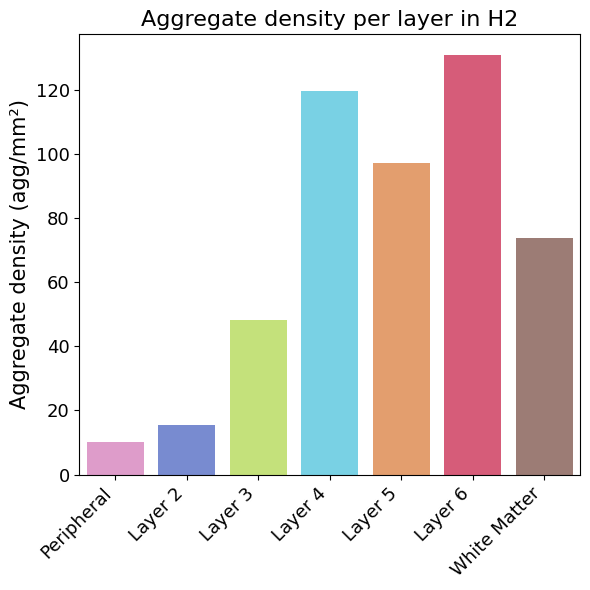

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2481750151.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


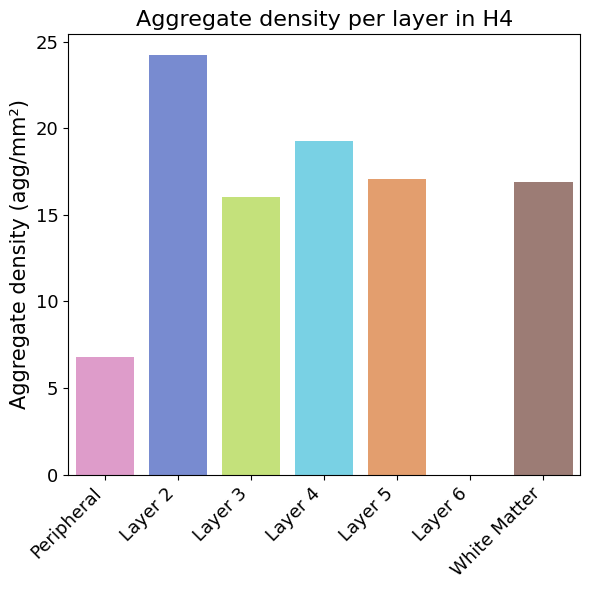

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2481750151.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


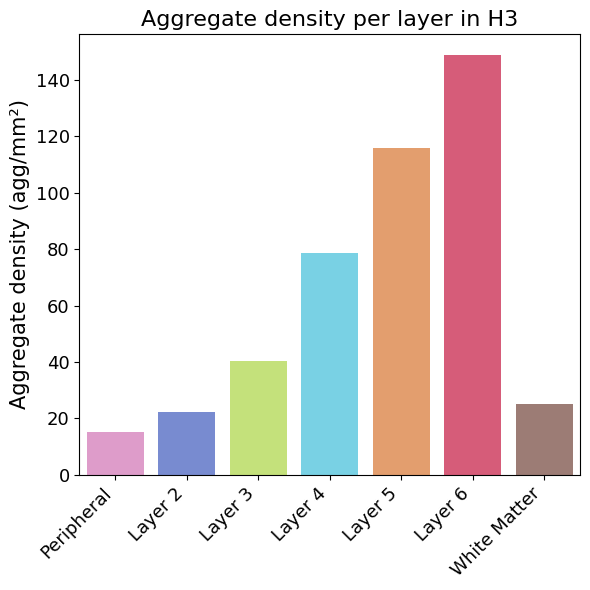

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2481750151.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


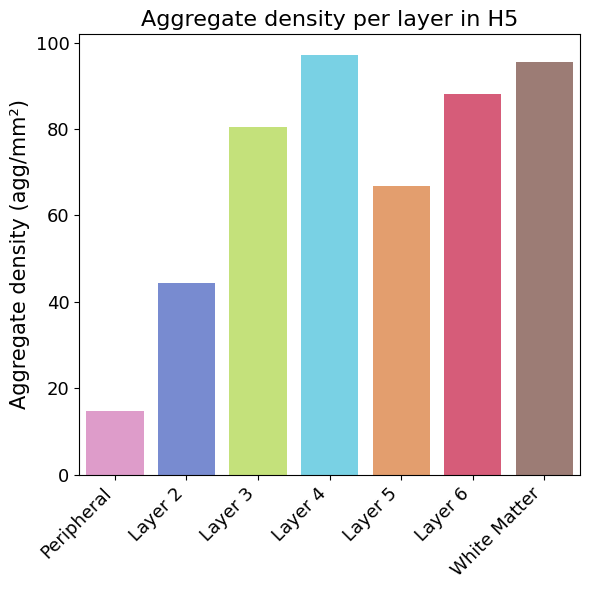

In [27]:
for pt in upatientHD:
    df= density_long[density_long['patient']==pt].copy()
    plt.figure(figsize=(6, 6))
    
    # Barplot with means
    sns.barplot(
        data=df,
        x="Layer", y="Agg_Density",
        order=order_display,
        palette=colors_light_o,
        ci=None,
        alpha=0.8
    )
    
    
    plt.xticks(rotation=45, ha='right', fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel("Aggregate density (agg/mm²)", fontsize=15)
    plt.xlabel("")
    plt.title(f"Aggregate density per layer in {pt}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [28]:
##################################################
#### FIGURE 3H
##################################################

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/984175993.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


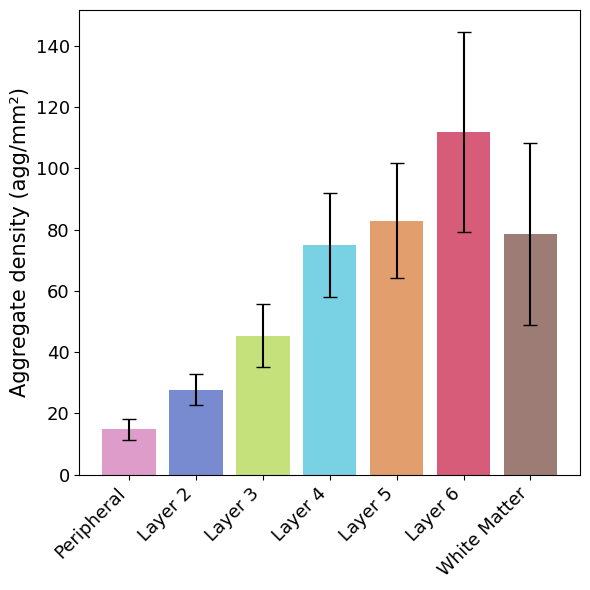

In [29]:
from scipy.stats import sem
plt.figure(figsize=(6, 6))

sns.barplot(
    data=density_long,
    x="Layer", y="Agg_Density",
    order=order_display,
    palette=colors_light_o,
    ci=None,  # We'll add SEM manually
    alpha=0.8
)

means = density_long.groupby('Layer')['Agg_Density'].mean().reindex(order_display)
sems = density_long.groupby('Layer')['Agg_Density'].apply(sem).reindex(order_display)

x_coords = range(len(order_display))
plt.errorbar(
    x=x_coords,
    y=means,
    yerr=sems,
    fmt='none',
    ecolor='black',
    capsize=5,
    linewidth=1.5
)

plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Aggregate density (agg/mm²)", fontsize=15)
plt.xlabel("")
plt.tight_layout()
plt.show()


In [30]:
##################################################
#### SUPPLEMENTARY FIGURE 8I: Plot percent of cells with intranuclear aggregates per neuronal cluster
##################################################

In [31]:
Neurons=adata[adata.obs['cluster_general'].isin(['Inhibitory Neurons', 'Excitatory Neurons'])].copy()
Neurons_hd=Neurons[Neurons.obs['HD']==True].copy()

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/2008264827.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (patient, cluster) in data_df.groupby(['patient', 'cluster_names']):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gr

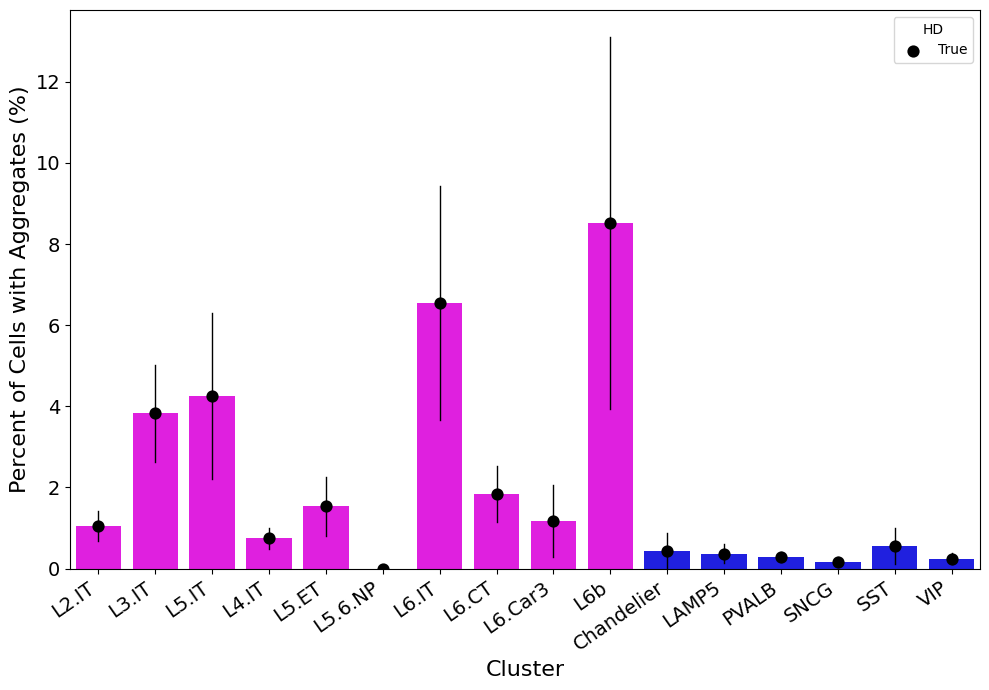

In [32]:
data_df = Neurons_hd.obs[['patient', 'cluster_names', 'Agg', 'HD']].copy()
data_df['Agg'] = data_df['Agg'].fillna(False).astype(bool)

agg_percentages_neurons = []
for (patient, cluster) in data_df.groupby(['patient', 'cluster_names']):
    total_cells = len(cluster)
    percent_with_agg = np.sum(cluster['Agg']) / total_cells * 100
    agg_percentages_neurons.append({
        'patient': patient,
        'cluster_names': cluster['cluster_names'].iloc[0],
        'percent_with_agg': percent_with_agg,
        'HD': str(cluster['HD'].iloc[0])
    })

agg_neu_percent_df = pd.DataFrame(agg_percentages_neurons)

cluster_order =['L2.IT', 'L3.IT', 'L5.IT', 'L4.IT', 'L5.ET', 'L5.6.NP', 'L6.IT', 'L6.CT', 'L6.Car3', 'L6b','Chandelier', 'LAMP5', 'PVALB', 'SNCG', 'SST', 'VIP' ]
agg_neu_percent_df['cluster_names'] = pd.Categorical(agg_neu_percent_df['cluster_names'], categories=cluster_order, ordered=True)

agg_stats_neu = agg_neu_percent_df.groupby(['cluster_names', 'HD'], observed=True).agg(mean_with_agg=('percent_with_agg', 'mean')).reset_index()

blue_clusters = ['Chandelier', 'LAMP5', 'PVALB', 'SNCG', 'SST', 'VIP']

cluster_color_map = {cluster: 'blue' if cluster in blue_clusters else 'magenta'
    for cluster in cluster_order}
se_palette = {'True': 'black', 'False': 'black'}

agg_neu_percent_df['cluster_color'] = agg_neu_percent_df['cluster_names'].map(cluster_color_map)
agg_stats_neu['cluster_color'] = agg_stats_neu['cluster_names'].map(cluster_color_map)

plt.figure(figsize=(10, 7))

for hd_val in agg_stats_neu['HD'].unique():
    sub_df = agg_stats_neu[agg_stats_neu['HD'] == hd_val]
    sns.barplot(
        x='cluster_names', y='mean_with_agg', data=sub_df,
        color=None, hue=None, palette=sub_df['cluster_color'],
        dodge=False, ax=plt.gca()
    )

sns.pointplot(
    x='cluster_names', y='percent_with_agg', hue='HD',
    data=agg_neu_percent_df, palette=se_palette, dodge=0.4, join=False,
    errorbar=('se', 1), errwidth=1, markers='o', linestyles=''
)

plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Percent of Cells with Aggregates (%)', fontsize=16)
plt.xticks(rotation=35, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [33]:
##################################################
#### FIGURE 3I
##################################################

In [34]:
percent_lost_df_neu = {
    'cluster_names': ['L2.IT', 'L3.IT', 'L5.IT', 'L4.IT', 'L5.ET', 'L5.6.NP', 'L6.IT', 'L6.CT', 'L6.Car3', 'L6b','Chandelier', 'LAMP5', 'PVALB', 'SNCG', 'SST', 'VIP' ],
    'Percent Lost': [38.965629, 7.597639, 21.390964, 44.542414, 9.159061, 84.112792, 24.816347, 42.304075, 2.011352, 53.409478,55.550050,7.380457, 14.008406,  -1.760563,   51.870968, 4.372169 ]
}

percent_lost_df_neu = pd.DataFrame(percent_lost_df_neu)
percent_lost_df_neu.set_index('cluster_names', inplace=True)
hd_stats_neu = agg_stats_neu.merge(percent_lost_df_neu, on='cluster_names', how='inner')
agg_stats_neu

,cluster_names,HD,mean_with_agg,cluster_color
0,L2.IT,True,1.049500,magenta
1,L3.IT,True,3.826079,magenta
2,L5.IT,True,4.254942,magenta
3,L4.IT,True,0.745450,magenta
4,L5.ET,True,1.537347,magenta
5,L5.6.NP,True,0.000000,magenta
6,L6.IT,True,6.541321,magenta
7,L6.CT,True,1.841218,magenta
8,L6.Car3,True,1.185303,magenta
9,L6b,True,8.517164,magenta


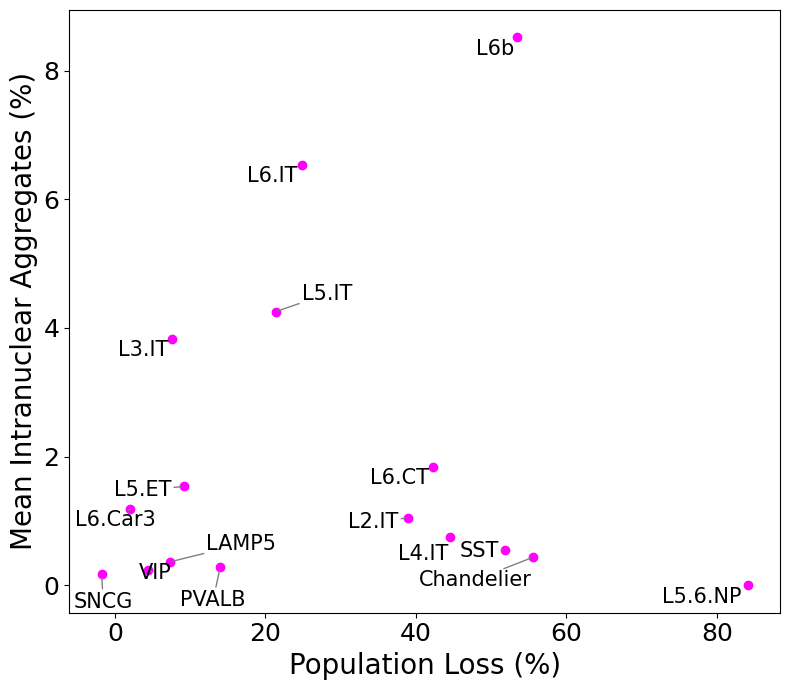

In [35]:
X = hd_stats_neu[['Percent Lost']] 
y = hd_stats_neu['mean_with_agg']  

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(8, 7))
plt.scatter(X, y, color='magenta', label='Data')

texts = []
for i, row in hd_stats_neu.iterrows():
    texts.append(plt.text(row['Percent Lost'], row['mean_with_agg'], row['cluster_names'], fontsize=15))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Population Loss (%)', size=20)
plt.ylabel('Mean Intranuclear Aggregates (%)', size=20)
plt.yticks(size=18)
plt.xticks(size=18)
plt.title('')
plt.tight_layout()
plt.show()

In [36]:
##################################################
#### SUPPLEMENTARY FIGURE 8J: Plot percent of cells with intranuclear aggregates per neuronal cluster
##################################################

In [37]:
Neurons_CTL=Neurons[Neurons.obs['HD']==False].copy()
HTT_CTL=Neurons_CTL.obs['nHTT'].copy()
df_HTT_CTL=pd.DataFrame(HTT_CTL.toarray() if hasattr(HTT_CTL, 'toarray') else HTT_CTL,index=Neurons_CTL.obs_names)
df_HTT_CTL['cluster_names'] = Neurons_CTL.obs['cluster_names'].values
HTT_CTL_expr_df_neu = df_HTT_CTL.groupby('cluster_names')['nHTT'].mean()

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_44963/4171752868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  HTT_CTL_expr_df_neu = df_HTT_CTL.groupby('cluster_names')['nHTT'].mean()


In [38]:
hd_stats_neu = hd_stats_neu.merge(HTT_CTL_expr_df_neu, on='cluster_names', how='inner')
hd_stats_neu

,cluster_names,HD,mean_with_agg,cluster_color,Percent Lost,nHTT
0,L2.IT,True,1.049500,magenta,38.965629,18.552198
1,L3.IT,True,3.826079,magenta,7.597639,25.347062
2,L5.IT,True,4.254942,magenta,21.390964,23.508972
3,L4.IT,True,0.745450,magenta,44.542414,16.471417
4,L5.ET,True,1.537347,magenta,9.159061,36.025210
5,L5.6.NP,True,0.000000,magenta,84.112792,17.446629
6,L6.IT,True,6.541321,magenta,24.816347,21.326152
7,L6.CT,True,1.841218,magenta,42.304075,16.172662
8,L6.Car3,True,1.185303,magenta,2.011352,19.260726
9,L6b,True,8.517164,magenta,53.409478,18.714536


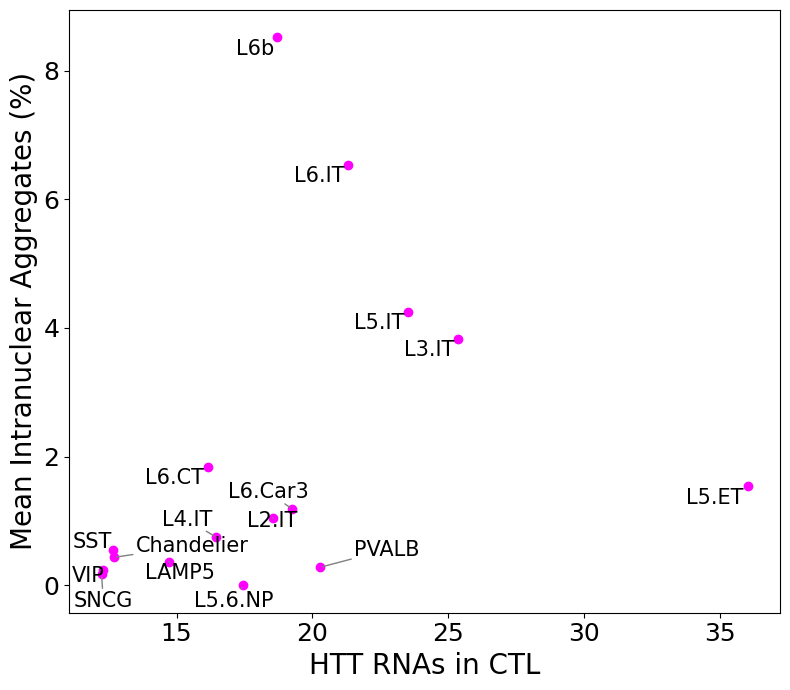

In [39]:
X = hd_stats_neu[['nHTT']]
y = hd_stats_neu['mean_with_agg']  

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(8, 7))
plt.scatter(X, y, color='magenta', label='Data')

texts = []
for i, row in hd_stats_neu.iterrows():
    texts.append(plt.text(row['nHTT'], row['mean_with_agg'], row['cluster_names'], fontsize=15))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('HTT RNAs in CTL', size=20)
plt.ylabel('Mean Intranuclear Aggregates (%)', size=20)
plt.yticks(size=18)
plt.xticks(size=18)
plt.title('')
plt.tight_layout()
plt.show()